In [63]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

## Опрос в начале лекции
https://docs.google.com/forms/d/e/1FAIpQLSda7O_EcibA0-id7hpTDRZ6Lhom6IeQjcBtJEyAZEc-PKgw6A/viewform?usp=sf_link

## План лекции
- bias-variance tradeoff
- композиции алгоритмов (in general)
- bootstrap
- bagging
- RSM (random subsampling method)
- RandomForest
  * алгоритм
  * oob
  * важности признаков
- Boosting
  * adaboost
- Blending, stacking

## Bias variance tradeoff

https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Bias-variance-Tradeoff.php

https://en.wikipedia.org/wiki/Bias–variance_tradeoff

$Bias[f'(x)] = E[f'(x) - f(x)]$<br>
$Var[f'(x)] = E[f'(x)^2] - (E[f'(x)])^2$<br>


$E[(f(x) - f'(x))^2] = (Bias[f'(x)])^2 + Var[f'(x)] + \sigma^2$

Вывод формулы

$$E[(y - f')^2] = E[y^2 + f'^2 - 2 y f'] = E[y^2] + E[f'^2] - E[2yf'] = Var[y] + E[y]^2 + Var[f'] + E[f]^2 - 2fE[f'] = Var[y] + Var[f'] + (f - E[f'])^2 $$

# Ансамбли моделей


### Мудрость толпы

Если спросить много людей о некоторой характеристике и усреднить - получится результат лучше, чем полученный от одного эксперта.  

В онлайне размещена картинка с коровой. Люди заходят на сайт и дают оценку ее веса. Средний результат из 17000 предсказаний отклоняется от действительного значения на 5%.

https://en.wikipedia.org/wiki/Wisdom_of_the_crowd

https://www.amazon.com/Wisdom-Crowds-James-Surowiecki/dp/0385721706

### Теорема Кондорсе «о жюри присяжных»

https://ru.wikipedia.org/wiki/Парадокс_Кондорсе

### Netflix prize

Объявлен приз в 1 млн. долларов за улучшение предсказания на 10%. После построения простых качественных моделей составляются ансамбли из моделей. Это комбинирование простых моделей в одну более сложную, делающую более качественное предсказание.

https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf

## Voting Classifiers

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

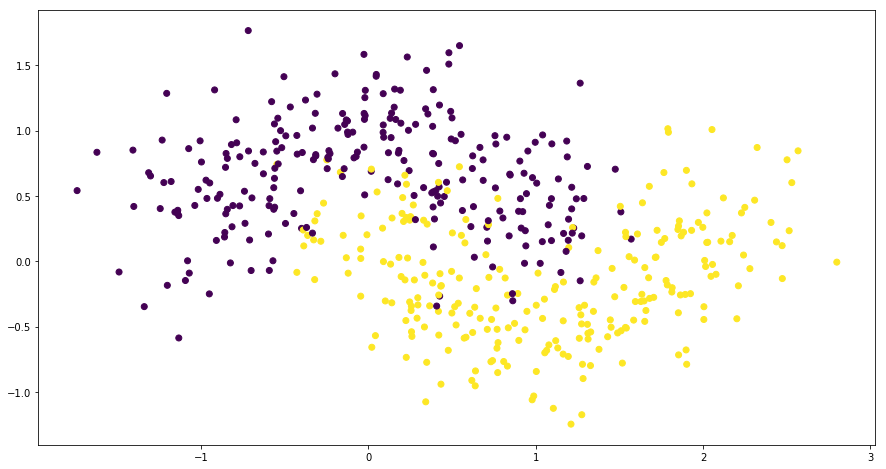

In [65]:
plt.scatter(X[:, 0], X[:, 1], c=y)

### Hard voting
Построим несколько простых моделей на одних и тех же данных.  
Предсказание будем делать всеми моделями, в результате предсказания выберем тот класс, за который проголосовало большинство моделей - **hard voting**

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [68]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Soft voting
Если все классификаторы могут вернуть вероятность (реализован метод predict proba), то можем посчитать среднее - **soft voting**

In [70]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [71]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
voting_clf.predict_proba(X_test)

array([[0.55611089, 0.44388911],
       [0.80333358, 0.19666642],
       [0.65955121, 0.34044879],
       [0.01814628, 0.98185372],
       [0.05134482, 0.94865518],
       [0.15924051, 0.84075949],
       [0.9867671 , 0.0132329 ],
       [0.98152668, 0.01847332],
       [0.67056686, 0.32943314],
       [0.97606993, 0.02393007],
       [0.01518898, 0.98481102],
       [0.98586598, 0.01413402],
       [0.06419684, 0.93580316],
       [0.19269823, 0.80730177],
       [0.0758089 , 0.9241911 ],
       [0.92570277, 0.07429723],
       [0.97786368, 0.02213632],
       [0.05877976, 0.94122024],
       [0.20202757, 0.79797243],
       [0.93547522, 0.06452478],
       [0.95414873, 0.04585127],
       [0.15762376, 0.84237624],
       [0.43418963, 0.56581037],
       [0.80736295, 0.19263705],
       [0.93426248, 0.06573752],
       [0.81541138, 0.18458862],
       [0.18637412, 0.81362588],
       [0.9866982 , 0.0133018 ],
       [0.0206927 , 0.9793073 ],
       [0.98388717, 0.01611283],
       [0.

На ирисах:

In [74]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.900 (+/- 0.05) [Logistic Regression]
Accuracy: 0.933 (+/- 0.05) [Random Forest]
Accuracy: 0.913 (+/- 0.04) [naive Bayes]


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklear

Accuracy: 0.947 (+/- 0.05) [Ensemble]


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [75]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1, 1, 1])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)


for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.947 (+/- 0.03) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.947 (+/- 0.05) [Ensemble]


/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklear

### Подбор параметров

In [76]:
from sklearn.model_selection import GridSearchCV
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklear

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/sklear

In [77]:
grid.best_estimator_

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFore...   oob_score=False, random_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

## Bootstrap

$N$ раз выбираем элементы с повторением из выборки. Сгенерируем $M$ подвыборок $X_1, X_2,...,X_m$. По каждой из данных выборок мы можем оценивать различные статистики.

<img src='pics/bootstrap-sample.png'>

(array([ 1.,  2.,  4.,  9.,  7.,  7., 11., 43., 53., 51., 30., 25., 18.,
        12.,  9.,  8.,  4.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  2.]),
 array([-2.32563797, -2.00722425, -1.68881053, -1.3703968 , -1.05198308,
        -0.73356936, -0.41515564, -0.09674192,  0.2216718 ,  0.54008552,
         0.85849924,  1.17691296,  1.49532668,  1.8137404 ,  2.13215412,
         2.45056784,  2.76898156,  3.08739528,  3.405809  ,  3.72422272,
         4.04263644,  4.36105016,  4.67946388,  4.9978776 ,  5.31629132,
         5.63470504]),
 <a list of 1 Patch objects>)

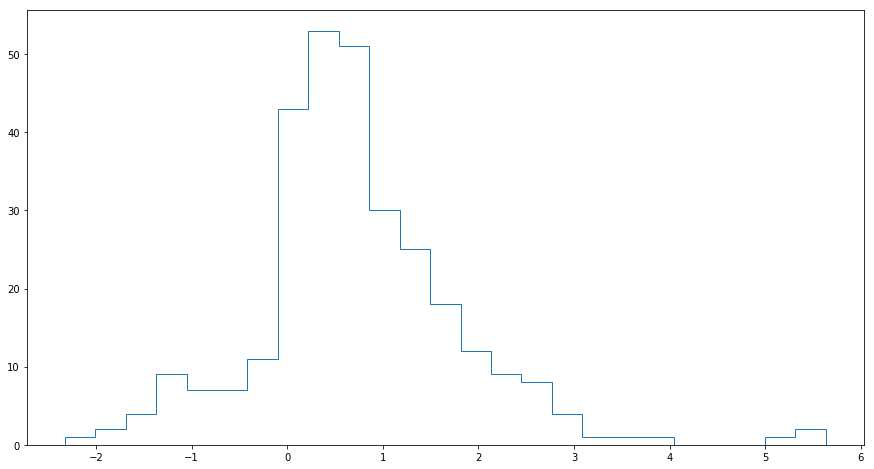

In [78]:
# For example, what is the 95% confidence interval for
# the mean of this data set

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step')

In [79]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = xb.mean(axis=0)
mb.sort()

np.percentile(mb, [2.5, 97.5])

array([0.61667477, 0.86533912])

# Bagging - bootstrap aggregation

Из выборки генерируем сэмпл. Сэмплирование делаем с возвращением.

In [80]:
def subsample(data, ratio=1.0):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [81]:
dataset = np.random.randint(0, 1000, size=1000)

In [82]:
dataset

array([980, 453,  35, 115, 266,  43, 601, 991, 942, 340, 932,  21, 896,
       384, 971, 350, 544, 533, 552,  82, 622, 501, 627, 122, 655, 130,
       477,  10, 954, 113, 396, 491, 499,  51, 451, 918, 443, 351, 570,
       204, 881, 465, 341, 464, 374,  44, 975, 656, 731, 971, 643, 943,
       569, 837, 841, 712, 845, 455,   5, 430, 772, 553, 225, 605, 439,
       525, 462, 920, 889, 425, 968, 261, 291, 834, 281, 922, 916, 428,
       259, 887, 742, 918, 737, 784, 291,  87,  36,  79, 898, 592, 790,
       507, 360, 319, 182, 540,  78, 339, 270, 912, 813, 396, 579, 199,
       257, 679, 262, 520, 252, 646, 553, 269, 819, 110, 305, 207, 997,
       877, 290, 409, 227,  97, 543, 787,  10, 362, 385, 302, 519, 693,
       216, 864, 385,   4, 954, 322, 798, 798, 109, 834, 340, 646,  53,
        55, 380, 348,  13, 943, 184, 338, 302, 824, 889, 643, 327, 542,
       795,   3, 623, 507, 164, 462,  51, 885, 677, 334, 628, 527,  83,
       440, 803, 554, 869, 914, 531, 287, 129,  36, 189, 966, 16

In [83]:
np.unique(np.bincount(dataset))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [84]:
sample = subsample(dataset, ratio=0.4)

In [85]:
print(sample)

[709 908 513 576 824 666 853 553 167 396 787 941 227  36 747 249 531 421
 302 948 169 917 476 878 682 920 330 576 950 240  13 647 756  69 464   5
 918 415 210 300 227 555 980 447 598 311 899  24 756 967 552 790 772 106
 550 358 361   2 738 813 274 164 682 977 661 519 888 574 553  72 374 692
  79 197 122   2   7 144 694 316 790  79 586 351 954 112 980 390 227 609
 490 833 712 364  68 719 962 967 287 772 260  48 334 248 122 756 105 738
 786  97 881 552 866 224 940 608 883 238  89 616 834 159 737 936 990 824
 723 573 738 902 975 694 477 570  90 798 214 619 787  84 843 611 571 260
 383 568 737 813  44 154 343 355 680 661  52 720 129 396 427 750 562   2
 390 689 490 748 742 598 170 340 266 210 874 683 579 246 737 641 666 540
 692 499 986 738 490 109 959 434 945 949 301 747 605 212 916 498 338 443
  97 124 437 610 439 447 105 655 421 889  58 475 491 960 748 598 723 795
 866 849 105 388 881 719 311 723 532 666 214 837  69 151 904 462 475 105
 643 818 383 520 971 898 864 487  38  43 660 912 25

In [86]:
print(np.unique(np.bincount(sample)))

[0 1 2 3 4 5]


In [22]:
sample

array([ 73, 952, 535, 557, 892, 101, 257, 159,   0,  73, 862, 686, 904,
       880, 195,  40,  77, 321, 448, 260, 829, 886, 294, 603, 755, 158,
        57, 898, 227, 489,  76, 646, 674, 545, 209, 480, 685, 331, 666,
       663, 623, 557, 793, 968, 898, 206, 522, 275, 610, 637, 538, 243,
       616, 736,  11, 148, 109, 842,  94, 336, 330, 321, 972, 363, 225,
       696, 591, 700, 484,  78, 883, 201, 233, 743, 933, 720,  66, 887,
       840, 826, 789, 225, 888, 499, 888, 773, 763, 169, 830, 674, 962,
       176,   1,  30, 711, 686, 227,  57,  81, 818, 523, 204, 758, 749,
       387, 326, 717, 809, 985, 145, 416, 666, 805, 195,  62, 301,  19,
       367, 434, 864, 869, 326, 438, 592, 460,  62, 856, 844, 944,  73,
       667, 326, 233, 983, 950, 942, 325, 302, 848, 800, 942, 578,  30,
        14, 500, 540, 933, 327,  98, 560,  73, 457, 576, 717,  40, 976,
       763,  84, 700, 931, 399, 662, 222, 172, 361,   6, 326,  76, 809,
       818, 378,  19, 290, 170, 666, 287, 781, 888, 601, 390, 99

In [87]:
means = []
n_iterations = 1000
for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)
sum(means) / n_iterations

516.8082874999999

In [88]:
dataset.mean()

517.131

Основные идеи бэггинга:
* Сгенерировать подвыборку с возвращением, обучить модель.  
Для обучения будем использовать один и тот же алгоритм.  
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать результат (например, вычислить моду - самое частое или среднее предсказание)

Можно обучать параллельлно

### Упражнение (3 мин):
Какую компоненту ошибки уменьшает бэггинг?

http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


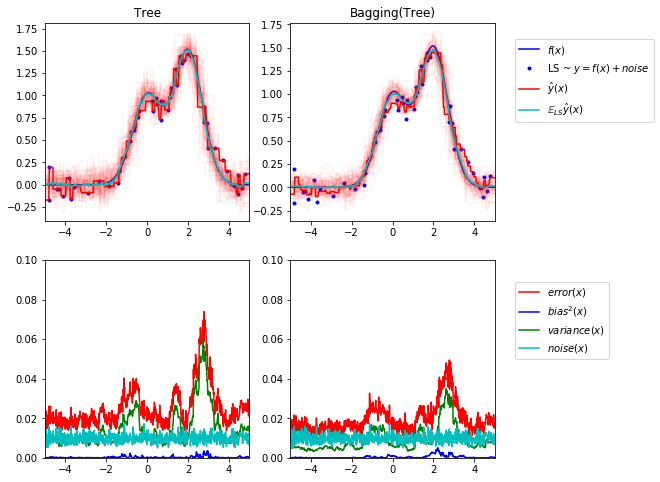

In [89]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

### Пример из scikit learn

In [90]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [92]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [93]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

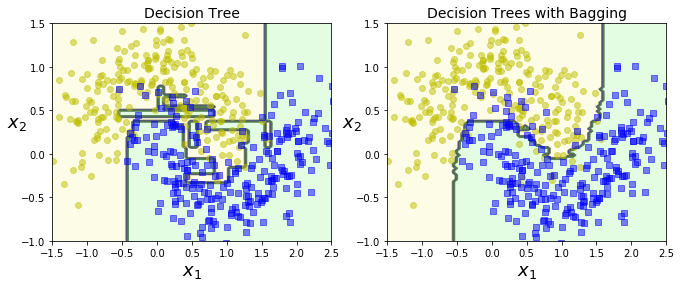

In [94]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random subspace method

Идея: брать случайные признаки.

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|1   | 0.1  |10  |
|2  | 0.2  | 20 |
|3   |  0.3 | 30  |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|1   | 0.1  | 0.01  |
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |
|4   |  0.4 |  0.04 |

* bootstrap=False
* max_samples=1.0
* bootstrap_features=True
* max_features < 1.0

## Random Patches method

Брать случайные признаки и случайные примеры

* bootstrap=True
* max_samples= < 1.0
* bootstrap_features=True
* max_features < 1.0

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|2  | 0.2  | 20 |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |

## Random forest

1. $X_1, X_2, ..., X_N$ -- объекты выборки, $f_1, f_2, ..., f_M$ -- признаки
2. $n_{models}$ -- количество моделей в ансамбле
3. Для каждой модели выбираем количество признаков $m \le M$
4. Для каждой из моделей бутстрэпим выборку и обучаем модель на ней
5. Результатом работы случайного леса будет усредненное значение результатов отдельных моделей.

Параметры RandomForestRegressor-a:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [95]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [96]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [97]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [98]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.976

### Ирисы

In [100]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [101]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

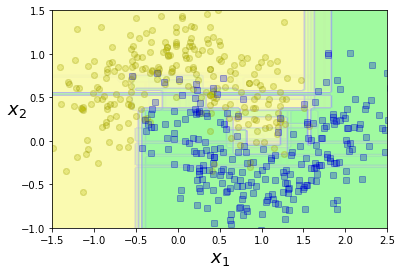

In [102]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# Out-of-bag error

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.


Out of bag error усредненная ошибка на 37% не используемых примерах.

<img src='pics/oobe.png'>

Слева то на чем тренируемся, справа то, на чем валидируемся.

# Важность признаков

### Упражнение
Как определить наиболее важные признаки?

## Замечание
- Чем выше признак, тем выше его важность.
- При оценке ошибки методом out-of-bag error можно сравнивать 2 различных набора признаков

Для того, чтобы оценить важность j-го параметра после тренировки, значения j-го параметра перемешиваются для всех записей тренировочного набора и out-of-bag-ошибка считается снова. Важность параметра оценивается путём усреднения по всем деревьям разности показателей out-of-bag-ошибок до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

In [103]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [104]:
mnist["data"].shape

(70000, 784)

In [105]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [106]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

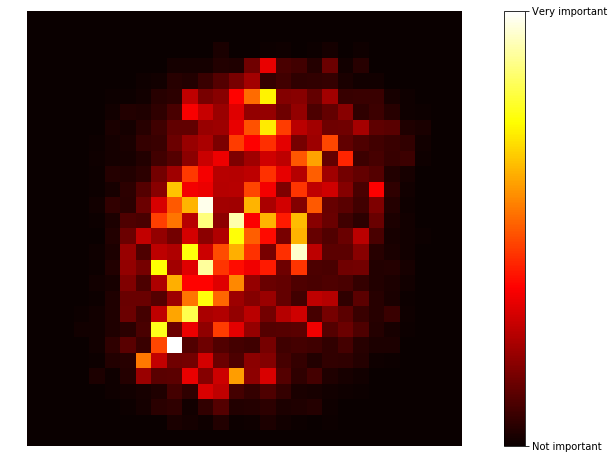

In [107]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees

Случайным образом выбирать порог для разбиения в узлах деревьев (случайный набор порогов -> выбираем лучший порог)

In [108]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

0.912
0.912


## Практические замечания

\+ RandomForest во многих задачах является сильным бейзлайном <br>
\+ хорошо работает на больших выборках (много признаков/много данных) <br>
\+ не сильно чувствителен к изменению параметров <br>
\+ не чувствителен к выбросам в данных из-за случайного сэмлирования <br>
\+ возвращает важности отдельных признаков <br>
\+ параллелизуется <br>
\+ не склонен к переобучению <br>

\- плохо работает на разреженных выборках <br>
\- занимает много памяти <br>
\- плохо интерпретируются <br>

# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.  
Из этих весов сможем рассчитывать вес модели

In [110]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

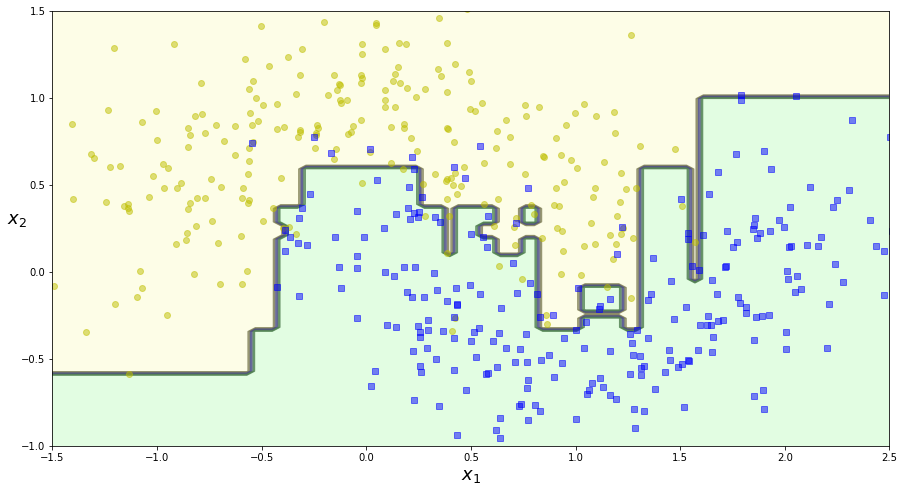

In [111]:
plot_decision_boundary(ada_clf, X, y)

Веса $w_i$ каждого обучающего примера $X_i$
$$X = \begin{bmatrix} 
a_1 & b_1 & c_1 & ... \\ 
a_2 & b_2 & c_2 & ... \\ 
a_3 & b_3 & c_3 & ... \\
... & ... & ... & ...
\end{bmatrix}, \space 
w = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 \\
... 
\end{bmatrix}$$

initially

$$w_i = \frac{1}{m}$$


$m$ - количество примеров в обучающей выборке (количество строк в $X$)

Обучаем модель и считаем ее error rate:


$$r = \frac{\sum\limits_{\hat{y} \neq y}{w}}{\sum w}$$

Чем больше ошибок, тем больше $r$

Считаем вес модели:

$$ \alpha = \eta log \frac{1-r}{r} $$

/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/an/Projects/otus/otus-datamining/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


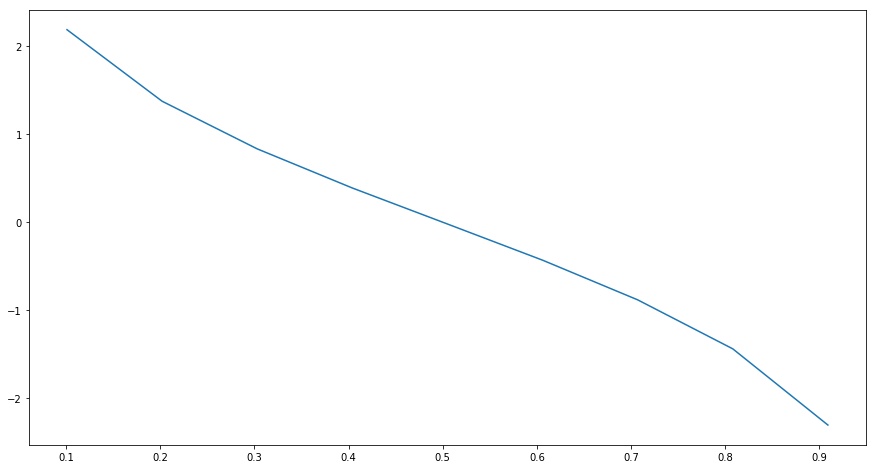

In [112]:
def f(x):
    return np.log((1 - x) / x)

x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y)

Обновим веса:

$w$ не меняется, если предсказание верное   
$w \leftarrow w \cdot e^{\alpha} $, если предсказание ошибочное

Все веса нормализуются, делятся на $\sum w$

# Stacking, blending

In [113]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [115]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 

In [117]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [118]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [120]:
accuracy_score(y_test, y_stack)

0.864

In [121]:
accuracy_score(y_test, rnd_clf.predict(X_test))

0.904

## Задача:
есть несколько базовых алгоритмов SVM, KNN, DecisionTree и несколько способов их композиции бэггинг, бустинг.
Для каких базовых алгоритмов какие способы композиции будут работать лучше? При необходимости нужно провести эксперименты.

## Дополнительные материалы:
[Bias Variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)


http://scott.fortmann-roe.com/docs/BiasVariance.html

[Заметка А.Дьяконова о случайных лесах](https://dyakonov.org/2016/11/14/случайный-лес-random-forest/)

https://www.kaggle.com/general/18793  

https://github.com/viisar/brew

[Важная презентация про случайный лес](http://docs.salford-systems.com/AdeleCutler.pdf)

[Статья А.Дьяконова про блендинг и стекинг](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)

## Фидбек

https://otus.ru/polls/1986/